In [1]:
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
from tqdm import tqdm
from scipy.stats import iqr
from sklearn.metrics import adjusted_mutual_info_score

from cplAE_TE.utils.load_helpers import get_paths, load_dataset, load_summary_files
from cplAE_TE.utils.compute import contingency, contingency_metric
from cplAE_TE.utils.plots import matrix_scatterplot

%config InlineBackend.figure_format = "svg"
%matplotlib inline

#### Unsupervised clustering: Finding optimal number of clusters

- The coupled autoencoder was initialized 21 times with the same train-test data split. 
- Gaussian Mixture Model (GMM) with different number of components were fit to coupled representation ($z_t$) from each run.
- Bayesian Information Critereon (BIC) calculated on the training set was used to estimate the optimal number of components. 

In [2]:
# collect GMM fitting results from each run, for different number of GMM components
path = get_paths()
df_list = []
for n_gmm_components in tqdm(np.arange(10,45,1)):
    for i in range(21):
        fname = path['exp_repeat_init_gmm'] / f'gmmfit_restricted_perc_100-0_aT_1-0_aE_1-0_cs_1-0_ad_1_cv_0_ri_{i}_ld_3_ne_1500_fiton_zTminn_{n_gmm_components}_maxn_{n_gmm_components+1}.csv'
        df = pd.read_csv(fname)
        df['init']=i
        df_list.append(df)
df = pd.concat(df_list)
del df_list

100%|██████████| 35/35 [00:01<00:00, 31.26it/s]


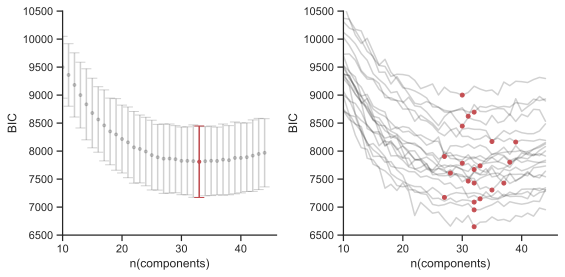

In [3]:
%matplotlib inline
sns.set(font_scale=1)
sns.set_style('ticks',{'axes.grid' : False})

# plot summary
plt.figure(figsize=(8,4))
plt.subplot(121)
qty = 'bic_train'
y_mean = df.groupby('n_components').mean()[[qty]]
y_sd = df.groupby('n_components').std()[[qty]]
opt_n_comp = y_mean[qty].idxmin()

plt.errorbar(x=y_mean.index.values, y=y_mean[qty].values, yerr=y_sd[qty].values,c='k',alpha=0.2,fmt='.',capsize=5)
plt.errorbar(x=opt_n_comp, y=y_mean[qty][opt_n_comp], yerr=y_sd[qty][opt_n_comp], fmt='.', c='r',capsize=5)

plot_attr={'xlabel':'n(components)',
            'ylabel':'BIC', 
            'xlim': (10,46), 
            'ylim': (6500,10500),
            'xticks': np.arange(10,44,10)}

ax = plt.gca()
sns.despine()
ax.set(**plot_attr)
plt.tight_layout()

# plot results on individual representations (from each coupled autoencoder run)
plt.subplot(122)
opt_n_comp_list=[]
opt_bic_list=[]
for i in range(21):
    df_this_run = df[df['init']==i]
    plt.plot(df_this_run['n_components'],df_this_run[qty],'-k',alpha=0.2)
    temp = df_this_run.loc[df_this_run[qty]==df_this_run[qty].min()]
    opt_bic_list.append(temp[qty].values[0])
    opt_n_comp_list.append(temp['n_components'].values[0])
    
plt.plot(opt_n_comp_list,opt_bic_list,'.r',markersize=8)
ax = plt.gca()
sns.despine()
ax.set(**plot_attr)
plt.tight_layout()

**Freedman-Diaconis rule** 

bin width $h = 2\times{IQ}\times{n^{−\frac{1}{3}}}$
 - IQ is the interquartile range
 - n is number of observations

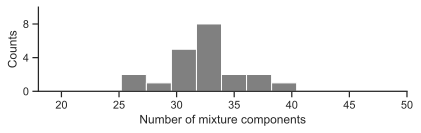

Binwidth from Freedman-Diaconis rule: 2.17
Ceiling of distribution mean: 33 <=== Optimal number of clusters


In [4]:
FD_binwidth = 2*iqr(opt_n_comp_list)*(len(opt_n_comp_list))**(-1/3)

plt.figure(figsize=(6,2))
plt.hist(opt_n_comp_list ,bins=np.arange(16,50,FD_binwidth)+0.5,color='gray')
ax = plt.gca()
ax.set(**{'xlabel':('Number of mixture components'), 
          'ylabel':('Counts'), 
          'ylim':(0,10), 'yticks':(np.arange(0,10,4)),
          'xlim':(18,47), 'xticks':(np.arange(20,51,5))})
plt.tight_layout()
sns.despine()
plt.show()

opt_n_components = int(np.ceil(np.mean(opt_n_comp_list)))
print(f'Binwidth from Freedman-Diaconis rule: {FD_binwidth:0.2f}')
print(f'Ceiling of distribution mean: {opt_n_components:d} <=== Optimal number of clusters') 

#### Analysis of unsupervised clusters

 - The same test/train split was used to train 21 coupled autoencoder models. 
 - 33 consensus clusters (from GMM fitting) are analyzed below.

In [5]:
# load dataset and all model initialization summaries
O = load_dataset(min_sample_thr=10)
CVdict = load_summary_files(data_type='NM_cc',
                            alpha_T=1.0,
                            alpha_E=1.0,
                            lambda_TE=1.0,
                            latent_dim=3,
                            aug=1,
                            fold_list=np.arange(21),
                            load_gmm=True,
                            n_components=opt_n_components,
                            key_list = ['XrE','XrT','zE','zT','train_ind','val_ind','test_ind'])

First we identify the *best* models based on reconstruction error

In [6]:
criteria = []
for i in CVdict.keys():
    # pre-calculate errors
    T_mse = np.mean((CVdict[i]['XrT']-O['XT'])**2, axis=1)
    E_mse = np.sum(O['maskE']*(CVdict[i]['XrE']-O['XE'])**2, axis=1)/np.sum(O['maskE'], axis=1)

    # define inliers based only on reconstruction errors:
    perc = 95
    test_ind = CVdict[i]['test_ind']
    T_inlier_ind = np.flatnonzero(T_mse < np.percentile(T_mse, perc))
    E_inlier_ind = np.flatnonzero(E_mse < np.percentile(E_mse, perc))
    TE_inliers = np.intersect1d(E_inlier_ind, T_inlier_ind)
    inlier_test_ind = np.intersect1d(test_ind, TE_inliers)

    # alpha_T = alpha_E = 1 in the loss function. Therefore, we simply add the T and E reconstruction losses.
    criteria.append(np.mean(T_mse[inlier_test_ind]) +
                    np.mean(E_mse[inlier_test_ind]))

In [7]:
# pick 5 of the best models based on criteria
n_best_models = 5
best_model_ind = np.argsort(criteria)
best_model_ind = best_model_ind[0:n_best_models]
print('Best model indices: ', best_model_ind)

Best model indices:  [11 17  1 14 10]


In [8]:
T_ami = np.full((n_best_models,n_best_models), np.nan)
E_ami = np.full((n_best_models,n_best_models), np.nan)

for subset in ['test_ind','train_ind']:
    for i,i_cv in enumerate(best_model_ind):
        for j,j_cv in enumerate(best_model_ind):
            if i>j:
                subset_ind_i = CVdict[i_cv][subset]
                subset_ind_j = CVdict[j_cv][subset]
                assert np.array_equal(subset_ind_i,subset_ind_j),'Error'
                
                T_ami[i,j] = adjusted_mutual_info_score(CVdict[i_cv]['ccT_lbl_matched'][subset_ind_i],
                                                        CVdict[j_cv]['ccT_lbl_matched'][subset_ind_j])
                
                E_ami[i,j] = adjusted_mutual_info_score(CVdict[i_cv]['ccE_lbl_matched'][subset_ind_i],
                                                        CVdict[j_cv]['ccE_lbl_matched'][subset_ind_j])

    print(f'T {subset} ami over pairwise compared models : {np.nanmean(T_ami):0.3f} + {np.nanstd(T_ami):0.3f}')
    print(f'E {subset} ami over pairwise compared models : {np.nanmean(E_ami):0.3f} + {np.nanstd(E_ami):0.3f}')

T test_ind ami over pairwise compared models : 0.660 + 0.009
E test_ind ami over pairwise compared models : 0.485 + 0.010
T train_ind ami over pairwise compared models : 0.716 + 0.010
E train_ind ami over pairwise compared models : 0.567 + 0.010


#### Consistency of *consensus clusters*

33-way partitions were obtained with GMM fit on $z_t$ (training set). These are referred to as *consensus clusters*. We show:
 - Consistency consensus cluster assignment to $X_t$ vs. $X_e$
 - Relationship of the consensus clusters to the cell type labels of the reference taxonomy

First, we show results for the test set cells only. Then we show the same plots for all the cells. 

In [9]:
X = CVdict[best_model_ind[0]]
opt_n_components = 33
unreliable_clusters_silhouette = [1, 13, 9, 28, 7, 17]  # Based on silhouette analysis for this fold (see relevant notebook)

sio.savemat(path['package'] / 'assets/consensus_cluster_labels.mat',
            {'consensus_cluster':np.array([f'TE-{x:02d}' for x in X['ccT_lbl_matched']]),
            'consensus_cluster_id':X['ccT_lbl_matched']},do_compression=True)

Total samples: 683
reliable cluster frac: 0.576


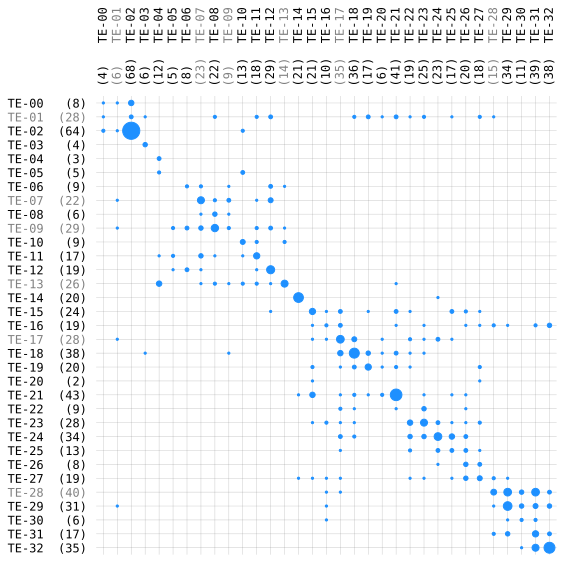

In [10]:
ind = X['test_ind']

# compare labels assigned to zT and zE by the GMM 
X['C_contingency'] = contingency(a=X['ccE_lbl_matched'][ind],
                                 b=X['ccT_lbl_matched'][ind],
                                 unique_a=np.arange(opt_n_components),
                                 unique_b=np.arange(opt_n_components))

# calculate heuristic measures of cluster reliability
_ = contingency_metric(X['C_contingency'].copy(), verbose=True)

#plot script
xname = [f'TE-{y:02d}' for y in np.arange(opt_n_components)]
xdata = [f'({np.sum(X["ccT_lbl_matched"][ind]==n):d})' for n in np.arange(opt_n_components)]
xlabelc = [f'{b:<6s}' + f'{a:s}' for (a, b) in zip(xname, xdata)]

yname = [f'TE-{y:02d}' for y in np.arange(opt_n_components)]
ydata = [f'({np.sum(X["ccE_lbl_matched"][ind]==n):d})' for n in np.arange(opt_n_components)]
ylabelc = [f'{a:6s}'+f'{b:>5s}' for (a, b) in zip(yname, ydata)]

ax = matrix_scatterplot(M=X['C_contingency'],
                        xticklabels=xlabelc,
                        yticklabels=ylabelc,
                        xlabel='',
                        ylabel='',
                        fig_width=8,
                        fig_height=8,
                        scale_factor=5.0)

cols = ['gray' if np.isin(i, unreliable_clusters_silhouette) else 'black' for i in range(X['C_contingency'].shape[0])]
for (i, t) in zip(cols, ax.xaxis.get_ticklabels()): t.set_color(i) 
for (i, t) in zip(list(reversed(cols)), ax.yaxis.get_ticklabels()): t.set_color(i)

#### Comparing *consensus clusters* with reference taxonomy cluster labels

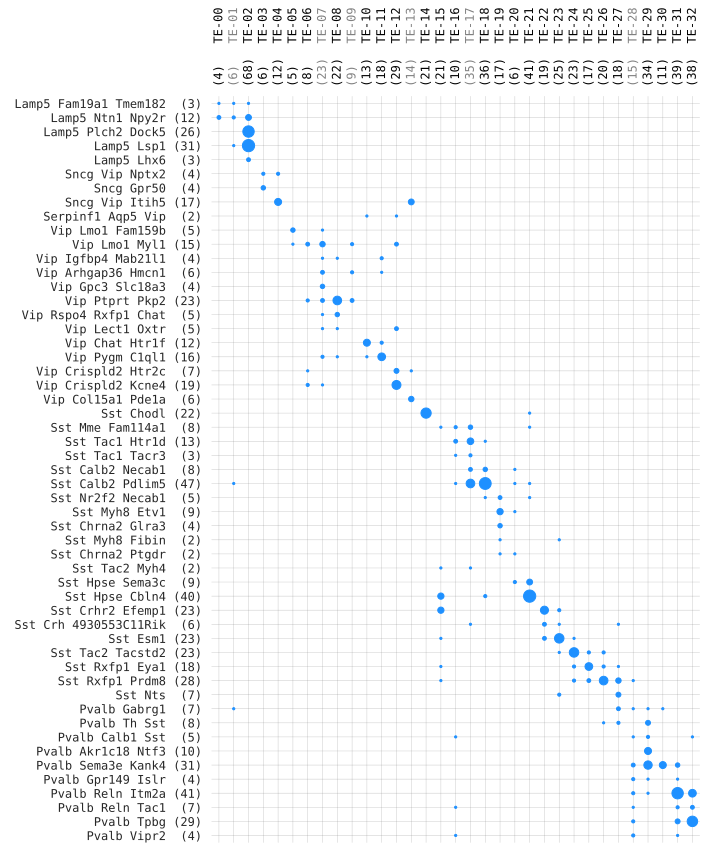

In [11]:
t_type_labels = deepcopy(O['cluster'])
t_types_well_sampled = deepcopy(O['well_sampled_sorted_t_types'])

# comparison with reference t-types
X['C_t_type'] = contingency(a=t_type_labels[ind],
                            b=X['ccT_lbl_matched'][ind],
                            unique_a=t_types_well_sampled,
                            unique_b=np.arange(opt_n_components))

xname = [f'TE-{y:02d}' for y in np.arange(opt_n_components)]
xdata = [f'({np.sum(X["ccT_lbl_matched"][ind]==n):d})' for n in np.arange(opt_n_components)]
xlabelc = [f'{b:<5s}' + f'{a:>6s}' for (a, b) in zip(xname, xdata)]

yname = [f'{t.rstrip()}' for t in t_types_well_sampled]
ydata = [f'({np.sum(O["cluster"][ind]==t)})' for t in t_types_well_sampled]
ylabelc = [f'{a:>22s}'+f'{b:>5s}' for (a, b) in zip(yname, ydata)]

ax = matrix_scatterplot(M=X['C_t_type'],
                        xticklabels=xlabelc,
                        yticklabels=ylabelc,
                        xlabel='',
                        ylabel='',
                        fig_width=10,
                        fig_height=12,
                        scale_factor=5.0)

cols = ['gray' if np.isin(i, unreliable_clusters_silhouette) else 'black' for i in range(X['C_t_type'].shape[1])]
for (i, t) in zip(cols, ax.xaxis.get_ticklabels()):
    t.set_color(i)
plt.show()

Same analysis, but with training and test cells put together

Total samples: 3411
reliable cluster frac: 0.848


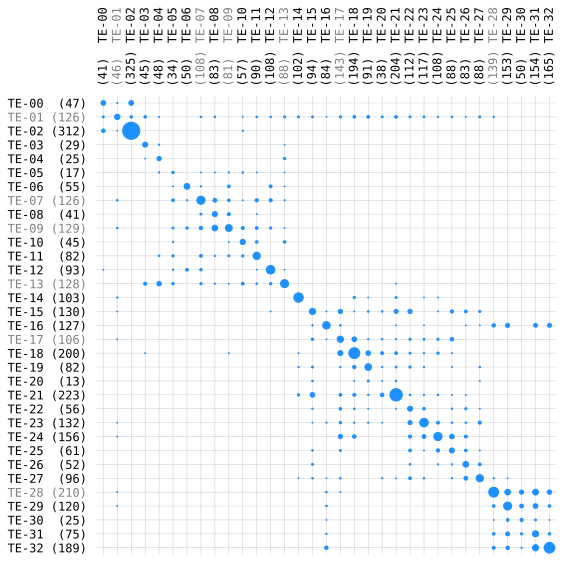

In [12]:
ind = np.concatenate([X['test_ind'],X['train_ind']])

# compare labels assigned to zT and zE by the GMM 
X['C_contingency'] = contingency(a=X['ccE_lbl_matched'][ind],
                                 b=X['ccT_lbl_matched'][ind],
                                 unique_a=np.arange(opt_n_components),
                                 unique_b=np.arange(opt_n_components))

# calculate heuristic measures of cluster reliability
_ = contingency_metric(X['C_contingency'].copy(), verbose=True)

#plot script
xname = [f'TE-{y:02d}' for y in np.arange(opt_n_components)]
xdata = [f'({np.sum(X["ccT_lbl_matched"][ind]==n):d})' for n in np.arange(opt_n_components)]
xlabelc = [f'{b:<6s}' + f'{a:s}' for (a, b) in zip(xname, xdata)]

yname = [f'TE-{y:02d}' for y in np.arange(opt_n_components)]
ydata = [f'({np.sum(X["ccE_lbl_matched"][ind]==n):d})' for n in np.arange(opt_n_components)]
ylabelc = [f'{a:6s}'+f'{b:>5s}' for (a, b) in zip(yname, ydata)]

ax = matrix_scatterplot(M=X['C_contingency'],
                        xticklabels=xlabelc,
                        yticklabels=ylabelc,
                        xlabel='',
                        ylabel='',
                        fig_width=8,
                        fig_height=8,
                        scale_factor=1.0)

cols = ['gray' if np.isin(i, unreliable_clusters_silhouette) else 'black' for i in range(X['C_contingency'].shape[0])]
for (i, t) in zip(cols, ax.xaxis.get_ticklabels()): t.set_color(i) 
for (i, t) in zip(list(reversed(cols)), ax.yaxis.get_ticklabels()): t.set_color(i)

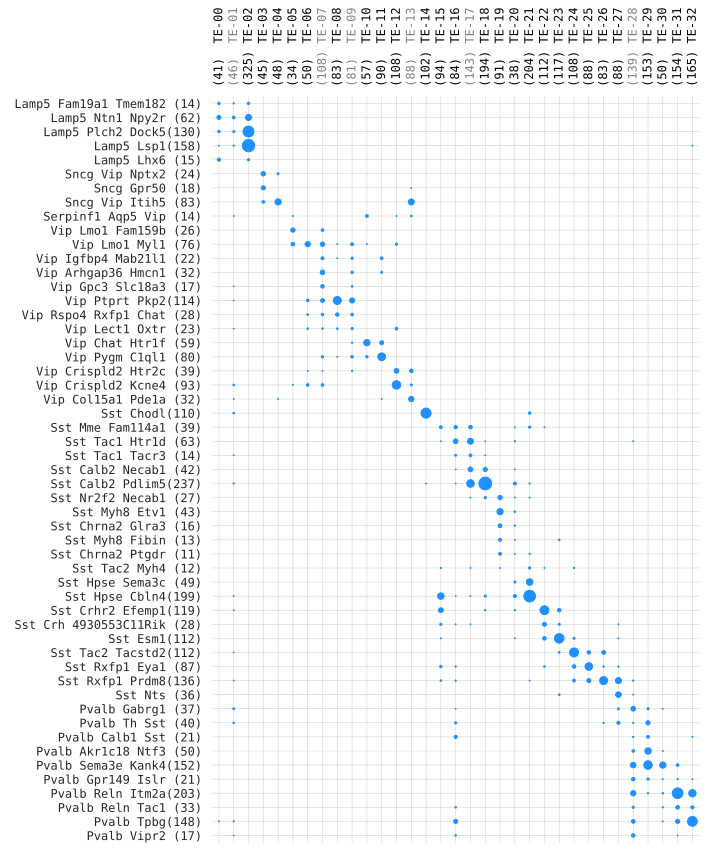

In [13]:
t_type_labels = deepcopy(O['cluster'])
t_types_well_sampled = deepcopy(O['well_sampled_sorted_t_types'])

# comparison with reference t-types
X['C_t_type'] = contingency(a=t_type_labels[ind],
                            b=X['ccT_lbl_matched'][ind],
                            unique_a=t_types_well_sampled,
                            unique_b=np.arange(opt_n_components))

xname = [f'TE-{y:02d}' for y in np.arange(opt_n_components)]
xdata = [f'({np.sum(X["ccT_lbl_matched"][ind]==n):d})' for n in np.arange(opt_n_components)]
xlabelc = [f'{b:<5s}' + f'{a:>6s}' for (a, b) in zip(xname, xdata)]

yname = [f'{t.rstrip()}' for t in t_types_well_sampled]
ydata = [f'({np.sum(O["cluster"][ind]==t)})' for t in t_types_well_sampled]
ylabelc = [f'{a:>22s}'+f'{b:>5s}' for (a, b) in zip(yname, ydata)]

ax = matrix_scatterplot(M=X['C_t_type'],
                        xticklabels=xlabelc,
                        yticklabels=ylabelc,
                        xlabel='',
                        ylabel='',
                        fig_width=10,
                        fig_height=12,
                        scale_factor=1.0)

cols = ['gray' if np.isin(i, unreliable_clusters_silhouette) else 'black' for i in range(X['C_t_type'].shape[1])]
for (i, t) in zip(cols, ax.xaxis.get_ticklabels()):
    t.set_color(i)
plt.show()

#### Get cluster labels based on GMM fit applied to coupled zT and zE 

In [ ]:
import scipy.io as sio
ref_tax_33 = sio.loadmat(path['anno_33_class_ref_tax'],squeeze_me=True)

In [ ]:
ref_path = '/home/rohan/Remote-AI/dat/result/TE_NM_cc/'
temp = sio.loadmat('/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/33_class_well_sampled_tasic.mat',squeeze_me=True)
reftax33 = temp['gt_labels']
reftax33_order = [t.rstrip().lstrip() for t in temp['ref_tax_33_order']]
reference_fold = sio.loadmat(ref_path+'NM_Edat_pcipfx_aT_1-0_aE_1-0_cs_1-0_ad_1_ld_3_bs_200_se_500_ne_1500_cv_0_ri_0_500_ft-summary.mat',squeeze_me=True)
ind_dict = {'train':reference_fold['train_ind'],'test':reference_fold['test_ind']}
ind_dict['train'] = ind_dict['train'][np.isin(ind_dict['train'],temp['keep_ind'])]
ind_dict['test'] = ind_dict['test'][np.isin(ind_dict['test'],temp['keep_ind'])]

In [ ]:
best_n_components = 33
for ri in CVdict.keys():
    fname = (f'gmmfit_restricted_perc_100-0_aT_{alpha_T:.1f}_aE_{alpha_E:.1f}_cs_{lambda_TE:.1f}_'+
            f'ad_1_cv_0_ri_{ri:d}_ld_3_ne_1500_fiton_zT_n_{best_n_components:d}').replace('.','-')+'.pkl'
    with open(gmm_pth+fname, 'rb') as fid:
        gmm = pickle.load(fid)

    #Label predictions using GMM fits:
    CVdict[ri]['ccT_lbl'] = gmm.predict(CVdict[ri]['zT'])
    CVdict[ri]['ccE_lbl'] = gmm.predict(CVdict[ri]['zE'])
    
    #Label prediction based on QDA:
    qda = QDA(reg_param=1e-2,store_covariance=True)
    train_ind = ind_dict['train']
    test_ind = ind_dict['test']
    all_ind = np.concatenate([ind_dict['train'],ind_dict['test']])

    qda.fit(CVdict[cv]['zE'][train_ind],reftax33[train_ind])
    lbl_pred_E = qda.predict(CVdict[cv]['zE'])

    qda.fit(CVdict[cv]['zT'][train_ind],reftax33[train_ind])
    lbl_pred_T = qda.predict(CVdict[cv]['zT'])

    CVdict[ri]['reftax_E_lbl_all'] = lbl_pred_E[all_ind]
    CVdict[ri]['reftax_T_lbl_all'] = lbl_pred_T[all_ind]
    CVdict[ri]['reftax_E_lbl_test'] = lbl_pred_E[test_ind] 
    CVdict[ri]['reftax_T_lbl_test'] = lbl_pred_T[test_ind] 
    
    CVdict[ri]['reftax_C_all'] = contingency(CVdict[ri]['reftax_E_lbl_all'],
                                            CVdict[ri]['reftax_T_lbl_all'],
                                            ref_tax_33_order,
                                            ref_tax_33_order)
            
    CVdict[ri]['reftax_C_test'] = contingency(CVdict[ri]['reftax_E_lbl_test'],
                                             CVdict[ri]['reftax_T_lbl_test'],
                                             ref_tax_33_order,
                                             ref_tax_33_order)